In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
%matplotlib inline

/Users/ryanbarouki/miniconda3/envs/pytorchenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [4]:
def build_dataset(words, block_size=3):
    block_size = 3
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = jnp.array(X)
    Y = jnp.array(Y)
    print(X.shape, X.dtype, Y.shape, Y.dtype)
    return X, Y

In [5]:
key = jax.random.PRNGKey(420+69)
# Split the data train/val/test at the word level
import random
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

(182541, 3) int32 (182541,) int32
(22805, 3) int32 (22805,) int32
(22800, 3) int32 (22800,) int32


In [7]:
print(f"Number of parameters: {sum([p.size for p in init_params])}")

Number of parameters: 12297


In [142]:
import modules as nn
import importlib
importlib.reload(nn)

<module 'modules' from '/Users/ryanbarouki/Documents/Coding/makemore_jax/modules.py'>

In [ ]:
emb_dim = 10
context_size = 3
hidden_size = 200
vocab_size = 27

init_fun, forward = nn.sequential([nn.Embedding(emb_dim=emb_dim, vocab_size=vocab_size),
                                   nn.Linear(fan_out=hidden_size),
                                   nn.BatchNorm(),
                                   nn.Tanh(),
                                   nn.Linear(fan_out=vocab_size)])

key = jax.random.PRNGKey(12121)
params_and_state = init_fun(key, jnp.ones(context_size))

In [148]:
def loss_fn(params, batch_stats, X, Y):
    logits, batch_stats = forward((params, batch_stats), X)
    return optax.losses.softmax_cross_entropy_with_integer_labels(logits, Y).mean(), batch_stats

@jax.jit
def train_step(params, batch_stats, X_batch, Y_batch, lr):
    (loss, batch_stats), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, batch_stats, X_batch, Y_batch)

    new_params = {}
    for layer_name, ps in params.items():
        gs = grads[layer_name]
        new_params[layer_name] = [p - lr * g for p,g in zip(ps, gs)]
    return loss, new_params, batch_stats

In [149]:
lossi = []
stepi = []

In [150]:

# USED TO DETERMINE GOOD LEARNING RATE
# lri = []
# lre = jnp.linspace(-3,0,1000)
#lr = 10**lre
# =====================================

# Training loop
batch_size = 32

params, batch_stats = params_and_state
for i in tqdm(range(200000)):
    lr = 0.1 if i < 100000 else 0.01
    # mini-batch
    key, subkey = jax.random.split(key)
    ix = jax.random.randint(subkey, (batch_size), 0, Xtr.shape[0])

    loss, params, batch_stats = train_step(params, batch_stats, Xtr[ix], Ytr[ix], lr)

    # Track stats to determine good learning rate
    # lri.append(lr[i])
    lossi.append(jnp.log10(loss))
    stepi.append(i)

print(loss)

100%|██████████| 200000/200000 [01:14<00:00, 2684.83it/s]

2.0655758


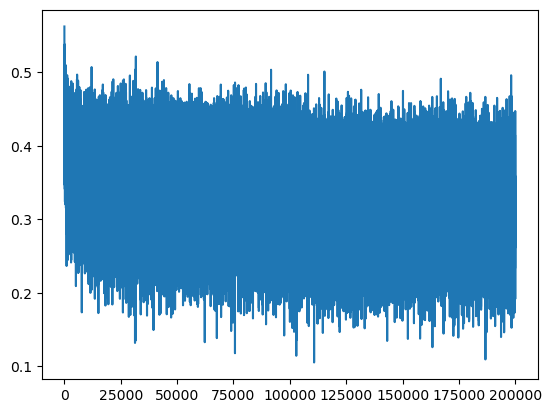

In [151]:
plt.plot(stepi, lossi)

In [152]:
#plt.plot(lri, lossi)
loss, _= loss_fn(params, batch_stats, Xdev, Ydev)
print(loss)

2.116177


In [155]:
# making sure you can apply the model to one example
logits, _= forward((params, batch_stats), Xdev[:1], train=False)
logits

Array([[-4.587569  ,  2.0131383 ,  0.590355  ,  1.0050657 ,  0.9086134 ,
         0.7550282 , -0.39427698, -0.02530485,  0.14582014, -0.14022791,
         1.366732  ,  1.6478351 ,  0.7478855 ,  1.4610298 ,  0.49938446,
        -0.41710424, -0.18620247, -1.994119  ,  0.62388897,  1.0664597 ,
         0.70614195, -2.3736742 , -0.57077414, -0.746392  , -1.6073556 ,
        -0.09376526,  0.29687285]], dtype=float32)

In [159]:
# Sample from the trained model

sample_key = jax.random.PRNGKey(4206969)

for _ in range(20):
    out = []
    context = [0] * 3

    sample_key, sample_sub_key = jax.random.split(sample_key)
    while True:
        sample_key, sample_sub_key = jax.random.split(sample_sub_key)
        logits, _ = forward((params, batch_stats), jnp.array([context]), train=False)
        ix = jax.random.categorical(sample_sub_key, logits)[0]
        context = context[1:] + [ix]
        out.append(int(ix))
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))


nazie.
jailin.
demarinab.
kemandwan.
zakarily.
chawn.
abhlaramaryus.
josley.
pyona.
christarik.
avi.
zovin.
quint.
aley.
toellah.
ani.
jaleu.
asrinha.
annox.
haze.
